In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *          

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection

# Regularization


Cross-validation helps you find a dimension for a fitted model that balances under- and over-fitting. Rather than selecting the dimension of the model, we can instead, build a large model but restrict the size of the coefficients.   To do this, we penalize the average square error from over-fitting by adding a penalty term on the size of the coefficients. We fit the model by minimizing the combination of mean squared error with a regularization term:

$$
\begin{aligned}
\frac{1}{n} \sum_{i=1}^{n}(y_i - \mathbf{x}_i \boldsymbol{\theta})^2  ~+~ \lambda \sum_{j = 1}^{p} \theta_j^2
\end{aligned}
$$


The regularization term $ \lambda \sum_{j = 1}^{p} \theta_j^2 $ penalizes large coefficients. The regularization parameter $\lambda$ determines the size of the penalty to apply, and we typically choose it through cross validation. 

Penalizing the square of the coefficients, is called $ L_2 $ regularization, and an $ L_2 $ regularized linear model is called *ridge regression*. Another popular regularization penalizes the absolute size of the coefficients. The  $ L_1 $ regularized linear model is called *Lasso regression*. (Lasso stands for Least Absolute Shrinkage and Selection Operator.)

$$
\begin{aligned}
\frac{1}{n} \sum_{i=1}^{n}(y_i - \mathbf{x}_i \boldsymbol{\theta})^2  ~+~ \lambda \sum_{j = 1}^{p} |\theta_j|
\end{aligned}
$$

We can think about what happens to this minimization when $ \lambda $ is really large. The coefficients are heavily penalized so they will shrink to 0. On the other hand, when $ \lambda $ is tiny, then the coefficients can take on any value. In fact, when $ \lambda $,  we're back in the world on ordinary least squares. A couple of issue crop up when we think about controlling the size of the coefficients. 
 
+ We do not want to regularize the intercept term. This way, a large  $ \lambda $ fits a constant model.
+ When features have very different scales, the penalty can impact them differently, with large-valued features being penalized more than others. To avoid this, we standardize all of the features to have mean 0 and variance 1.


## Regularizing a Market Analysis

A market research project for a pharmaceutical company wanted to model consumer interest in purchasing a cold sore healthcare product. They gathered data from 1023 consumers. Each consumer was asked to rate on a 10-point Likert scale 35 factors according to whether the factor matters to them when considering purchasing a cold sore treatment. They also rated their interest in purchasing the product.[^Lipovetsky] 

[^Lipovetsky]: Lipovetsky & Conklin (2015) Predictor relative importance
and matching regression parameters, Journal of Applied Statistics, 42:5, 1017-1031, https://doi.org/10.1080/02664763.2014.994480

In [2]:
ma_df = pd.read_csv('data/market-analysis.csv')

The table below contains the 35 factors and their correlation to their interest in purchasing the product. 


|  | Corr | Description |  | Corr | Description |
| --- | --- | --------- | --- | --- | --------- |
| x1  | 0.70 | provides soothing relief | x19 | 0.54 | has a non-messy application |
| x2  | 0.58 | moisturizes cold sore blister | x20 | 0.70 | good for any stage of a cold |
| x3  | 0.69 | provides long-lasting relief | x21 | 0.49 | easy to apply/take |
| x4  | 0.70 | provides fast-acting relief | x22 | 0.52 | package keeps from contamination |
| x5 | 0.72 | shortens duration of a cold | x23 | 0.57 | easy to dispense a right amount |
| x6  | 0.68 | stops the virus from spreading | x24 | 0.63 | worth the price it costs |
| x7 | 0.67| dries up cold sore | x25 | 0.57 | recommended most by pharamacists |
| x8 | 0.72 | heals fast | x26 | 0.54 | recommended by doctors |
| x9 | 0.72 | penetrates deep | x27 | 0.54 | FDA approved |
| x10 | 0.65 | relieves pain | x28 | 0.64 | a brand I trust |
| x11 |0.61 | prevents cold | x29 | 0.60 | clinically proven |
| x12 | 0.73 | prevents from getting worse | x30 | 0.68 | a brand I would recommend |
| x13 | 0.57 | medicated | x31 | 0.74 | an effective treatment |
| x14 | 0.61 | prescription strength | x32  |0.37 | portable |
| x15 | 0.63 | repairs damaged skin | x33 | 0.37 | discreet packaging |
| x16 | 0.67 | blocks virus from spreading | x34 | 0.55 | helps conceal cold sores |
| x17 | 0.42 | contains SPF | x35 | 0.63 | absorbs quickly |
| x18 | 0.57 | non-irritating | | | |


Some of these 35 features appear to be measuring similar aspects of desirability, based on their labels. We can compute the correlations between the explanatory variables to confirm this observation. 

In [3]:
ma_df.corr()

,y,x1,x2,x3,...,x32,x33,x34,x35
y,1.00,0.70,0.58,0.69,...,0.37,0.37,0.55,0.63
x1,0.70,1.00,0.69,0.74,...,0.42,0.33,0.57,0.71
x2,0.58,0.69,1.00,0.63,...,0.43,0.36,0.55,0.63
...,...,...,...,...,...,...,...,...,...
x33,0.37,0.33,0.36,0.34,...,0.34,1.00,0.35,0.36
x34,0.55,0.57,0.55,0.67,...,0.16,0.35,1.00,0.54
x35,0.63,0.71,0.63,0.70,...,0.46,0.36,0.54,1.00


We see, for example, the last feature, "absorbs quickly", is highly correlated with the first three: "provides soothing relief", "moisturizes", and "provides long-lasting relief".   

Before we start to fit regularized models, we set up the design matrix and output vector and split the data into train and test sets. We set aside 200 observations for the train set.

In [4]:
y = ma_df[['y']]
X = ma_df.drop(['y'], axis=1)

test_size = 200

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

As mentioned earlier, we need to standardize the features. We standardize the train set, and then, when we go to test the model, we use the train set standardization on the test set. The `StandardScaler` method helps us with this process.

In [5]:
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler().fit(X_train) 
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

The means of each of the 35 features in the train set are all 0 and the SDs are all 1. 

In [6]:
np.mean(X_train_scaled, axis=0)

array([ 0.,  0., -0., ..., -0.,  0.,  0.])

In [7]:
np.std(X_train_scaled, axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

This is not the case for the test set, because we have used the averages and SDs from train set to standardize them.

In [8]:
np.mean(X_test_scaled, axis=0)

array([-0.17, -0.12, -0.15, ..., -0.12, -0.1 , -0.24])

We perform a LASSO regression on the train set, setting $\lambda$ (represented as the parameter `alpha` in the call) 

In [9]:
from sklearn.linear_model import Lasso

lasso_model1 = Lasso(alpha=0.1)
lasso_model1.fit(X_train_scaled, y_train)

lasso_model1.coef_[0:20]

array([0.06, 0.  , 0.01, 0.  , 0.17, 0.  , 0.12, 0.02, 0.01, 0.  , 0.  ,
       0.24, 0.  , 0.  , 0.16, 0.  , 0.  , 0.  , 0.07, 0.02])

We see that several of the coefficients are 0. This is a property of LASSO regression that many find appealing. The nature of $L_1$ distance leads to coefficients being zeroed out, which can be viewed as a model selection technique.

In [10]:
sum(lasso_model1.coef_ > 0)

15

Twenty of the 35 coefficients are 0 in this model. 

Let's see how the coefficients change with $\lambda$. 

In [11]:
lasso_model = Lasso()
coefs = []
mses = []
alphas = np.arange(0.01, 2, 0.01)

for a in alphas:
    lasso_model.set_params(alpha = a)
    lasso_model.fit(X_train_scaled,y_train)
    coefs.append(lasso_model.coef_)
    mses.append(mean_squared_error(y_test, 
                    lasso_model.predict(X_test_scaled)))

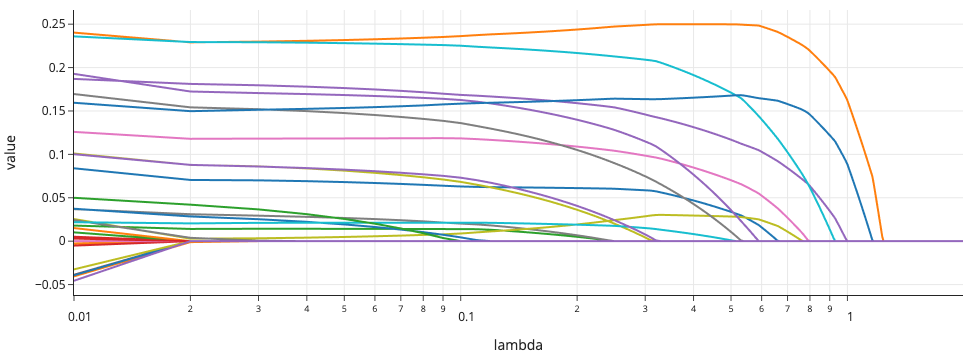

In [28]:
col_names = ["x" + str(v)
            for v in np.arange(1,36,1)]

coefs_df = pd.DataFrame(coefs, columns=col_names )

coefs_df[["lambda"]] = alphas 
coefs_long = pd.melt(coefs_df, id_vars='lambda', value_vars=col_names)


fig = px.line(coefs_long, x="lambda", y="value", color='variable', log_x=True)
fig.update_layout(showlegend=False, width=550, height=250)
fig.show()

As $ \lambda $ increases, the model fitting is penalized more heavily and many coefficients shrink to 0. The left hand side of the plot shows greater model complexity, corresponds to small $ \lambda $. The model that we first fit was for $ \lambda = 0.1 $, and we can see from this plot which coefficients are non-zero. The largest coefficients are for "x12", "x30", "x5", "x15", "x31", "x28", and "x7". 

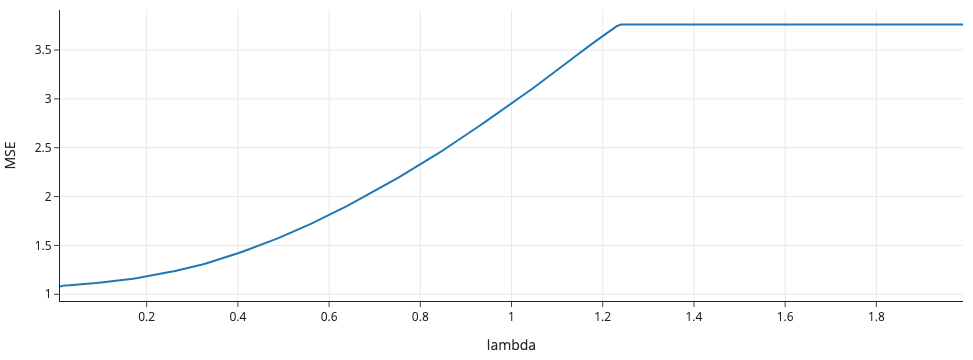

In [26]:
fig = px.line(x = alphas, y = mses,
             labels={"x": "lambda",
                     "y": "MSE"
                 })

fig.update_layout(width=350, height=250)
fig.show()

By the time $ \lambda $ is about 1.25, the penalty is so large that the LASSO regression is fitting a constant model to the data, and so the MSE remains the same. We are again faced with a model selection question, but this time it's in the form of deciding which $ \lambda $. We can use cross-validation to help us. 

In [14]:
from sklearn.linear_model import LassoCV

lasso_cv_model = LassoCV(alphas = np.arange(0.01, 1, 0.01), 
                         cv = 5, max_iter = 100000)

In [15]:
lasso_best = lasso_cv_model.fit(X_train_scaled, np.squeeze(y_train))

The penalty for the cross-validated model is:

In [16]:
lasso_best.alpha_

0.04

And we can compute the MSE for predictions in the test set using the cross-validated model. 

In [17]:
y_test_pred = lasso_best.predict(X_test_scaled)
mean_squared_error(y_test,y_test_pred)

1.0957444655340487

In [18]:
sum(lasso_best.coef_ > 0)

16

Similar to the model that we fitted first, there are 19 coefficients that are 0 in this model. 

Next, let's try using an $ L_2 $ penalty and perform Ridge regression. We'll make a plot of the coefficients as $ \lambda $ varies.

In [19]:
from sklearn.linear_model import Ridge

ridge = Ridge( )
coefsR = []
alphasR = np.arange(1, 1001, 25)

for a in alphasR:
    ridge.set_params(alpha = a)
    ridge.fit(X_train_scaled, y_train)
    coefsR.append(ridge.coef_)

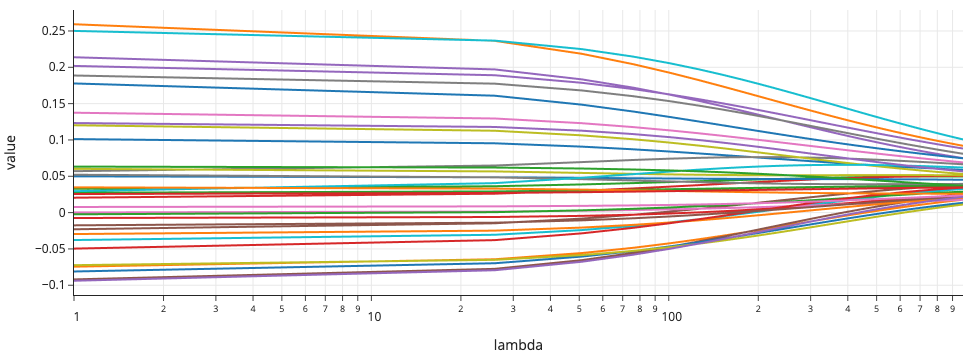

In [29]:
coefsR = np.squeeze(coefsR)

col_names = ["x" + str(v)
            for v in np.arange(1,36,1)]

coefsR_df = pd.DataFrame(coefsR, columns=col_names )
coefsR_df[["lambda"]] = alphasR 

coefsR_long = pd.melt(coefsR_df, id_vars='lambda', value_vars=col_names)

fig = px.line(coefsR_long, x="lambda", y="value", color='variable', log_x=True)
fig.update_layout(showlegend=False, width=550, height=250)
fig.show()

This plot shows a very different shape compared to the LASSO coefficient plot. The coefficients do not disappear entirely. The plots do have an important similarity in that as the penalty increases the coefficients shrink.  In a way, with Ridge regression, we are using all of the variables a little bit. Again, we are faced with the question of which $ \lambda $ to use, and we turn to cross-validation to help.

In [21]:
from sklearn.linear_model import RidgeCV

ridgecv = RidgeCV(alphas = alphasR, cv=10)
ridgecv.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([  1,  26,  51, ..., 926, 951, 976]), cv=10)

We use the cross-validated choice for $ \lambda $ to fit the Ridge regression. 

In [22]:
ridge_best = Ridge(alpha = ridgecv.alpha_)
ridge_best.fit(X_train_scaled, y_train)
mean_squared_error(y_test, ridge_best.predict(X_test_scaled))

1.1257716762997172

The MSE is larger than the MSE for LASSO. Many coefficients, while not 0, are quite small. We can count the number of coefficients larger than 0.05. 

In [23]:
sum(np.squeeze(ridge_best.coef_ > 0.05))

14

Similar to LASSO, roughly 20 of the features have tiny coefficients. We can compare the coefficients from the two regularized models.

In [24]:
ridge_best.coef_

array([[0.06, 0.02, 0.05, ..., 0.04, 0.03, 0.02]])

In [25]:
lasso_best.coef_[: 20]

array([ 0.07, -0.  ,  0.01,  0.  ,  0.18,  0.  ,  0.12,  0.03,  0.  ,
        0.  ,  0.02,  0.23,  0.  ,  0.  ,  0.17,  0.  ,  0.  ,  0.  ,
        0.08,  0.02])

Using $ L_1 $ or $ L_2 $ regularization, allows us to avoid model over-fitting by penalizing large coefficients.  $ L_1 $ regularization has the advantage of zeroing out coefficients. That is, Lasso regression performs *feature selection*—it discards a subset of the original features when fitting model parameters. This is particularly useful when working with high-dimensional data with many features. A model that only uses a few features to make a prediction will run much faster than a model that requires many calculations. Since unneeded features tend to increase model variance without decreasing bias, we can sometimes increase the accuracy of other models by using lasso regression to select a subset of features to use.

Sometimes we prefer one type of regularization over the other because it maps more closely to the domain we are working with. For example, if know that the phenomenon we are trying to model results from many small factors, we might prefer ridge regression because it won't discard these factors. On the other hand, some outcomes result from a few highly influential features. We prefer lasso regression in these situations because it will discard unneeded features.